# Evaluating U-Net and simple single convoluation baseline models

In [59]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
%reload_ext autoreload
import os
import sys

import numpy as np
import yaml

from ml_downscaling_emulator.evaluation import load_model, predict, open_test_set, compare_preds
from ml_downscaling_emulator.helpers import plots_at_ts
# dir2 = os.path.abspath('../../src/ml_downscaling_emulator/unet/unet')
# dir1 = os.path.dirname(dir2)
# if not dir1 in sys.path: sys.path.append(dir1)
# import unet
from ml_downscaling_emulator.unet import unet as unet
# weird hack as I moved the unet package foolishly
sys.modules['unet'] = unet

scale_factors = [2, 4, 8, 16, 27]

In [61]:
test_sets = {sf: open_test_set(f"../../../../derived_data/nc-datasets/2.2km-coarsened-{sf}x_london_pr/test.nc") for sf in scale_factors}

In [93]:
with open("../../experiments.yml", 'r') as file:
        experiments = yaml.safe_load(file)
        
model_job_ids = {"u-net": {}, "simple-conv": {}}
loss = "mse"
epochs = 200

for arch in ["simple-conv", "u-net"]:
    for sf in scale_factors:
        dataset = f"2.2km-coarsened-{sf}x_london_pr"
        experiment_run_id = f"{arch}-{dataset}-{loss}-{epochs}-epochs"
        model_job_ids[arch][sf] = experiments[experiment_run_id]["job_id"]

model_paths = {arch: {sf: f'../../../../derived_data/checkpoints/{arch}/{job_id}/model-epoch199.pth' for sf, job_id in jobs.items()} for arch, jobs in model_job_ids.items()}

preds = {}

In [94]:
preds["simple-conv"] = {sf: predict(load_model(model_path), test_sets[sf]) for sf, model_path in model_paths["simple-conv"].items()}

In [95]:
preds["u-net"] = {sf: predict(load_model(model_path), test_sets[sf]) for sf, model_path in model_paths["u-net"].items()}

## 2x coarsened

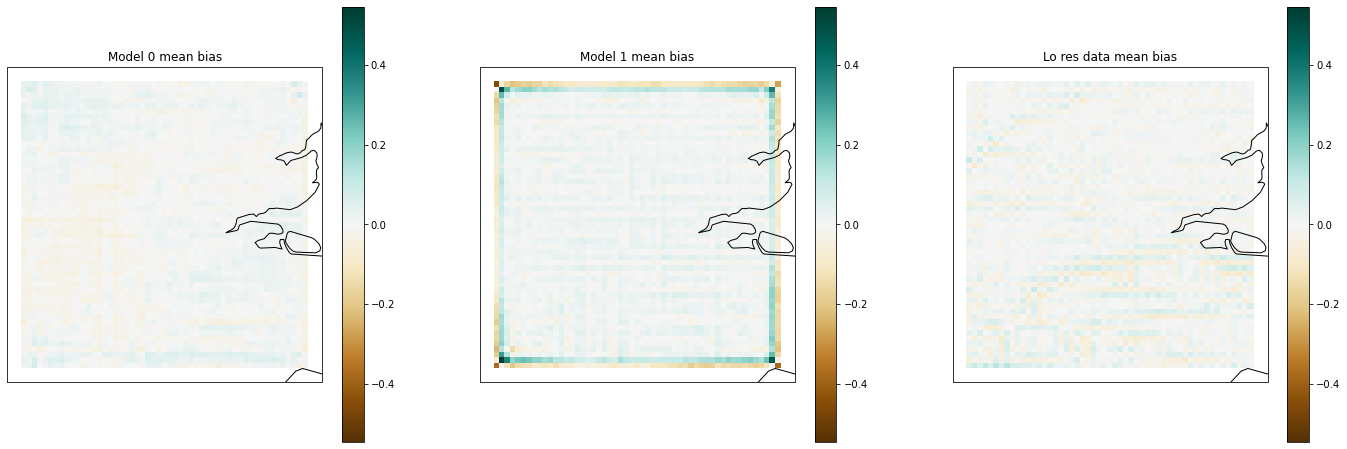

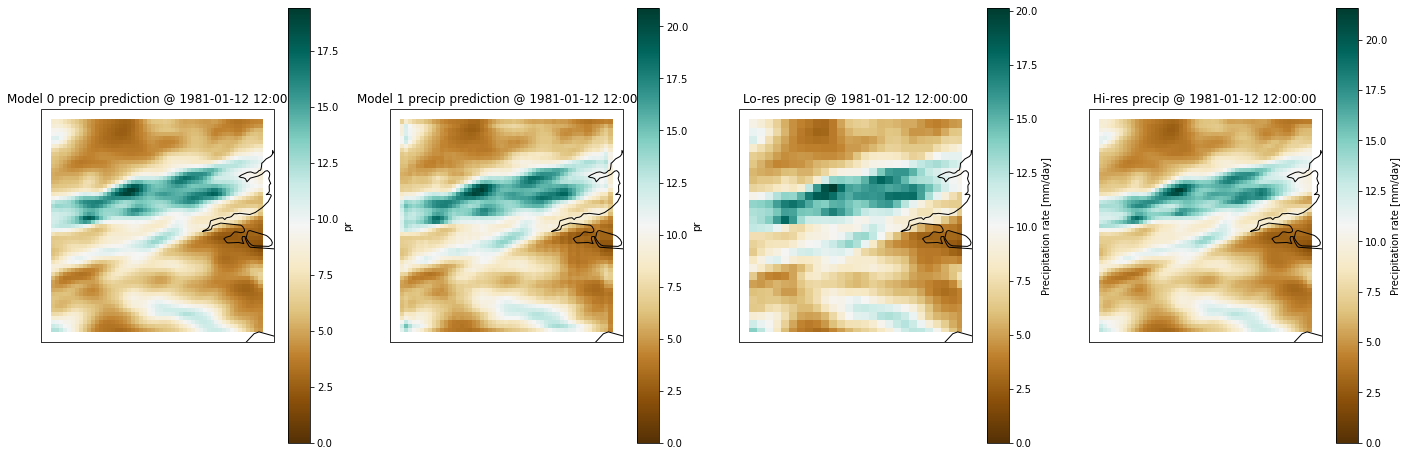

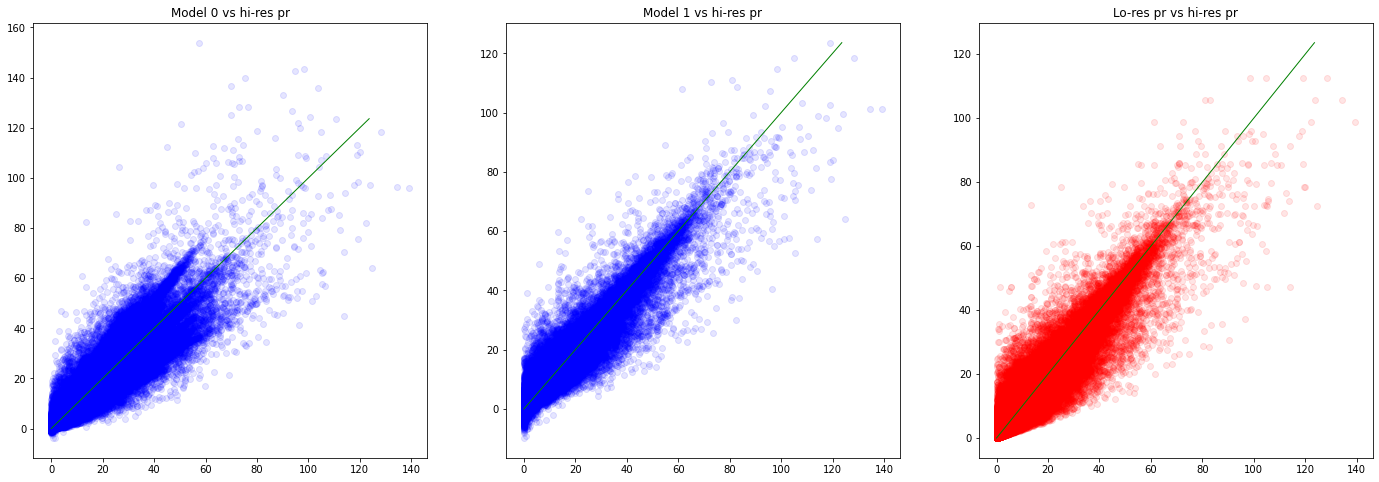

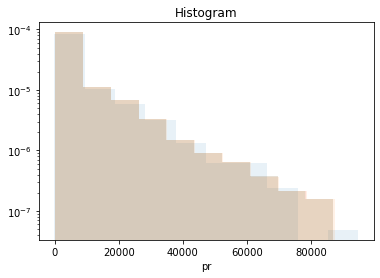

In [66]:
compare_preds([preds["u-net"][2], preds["simple-conv"][2]], test_sets[2])

## 4x coarsened

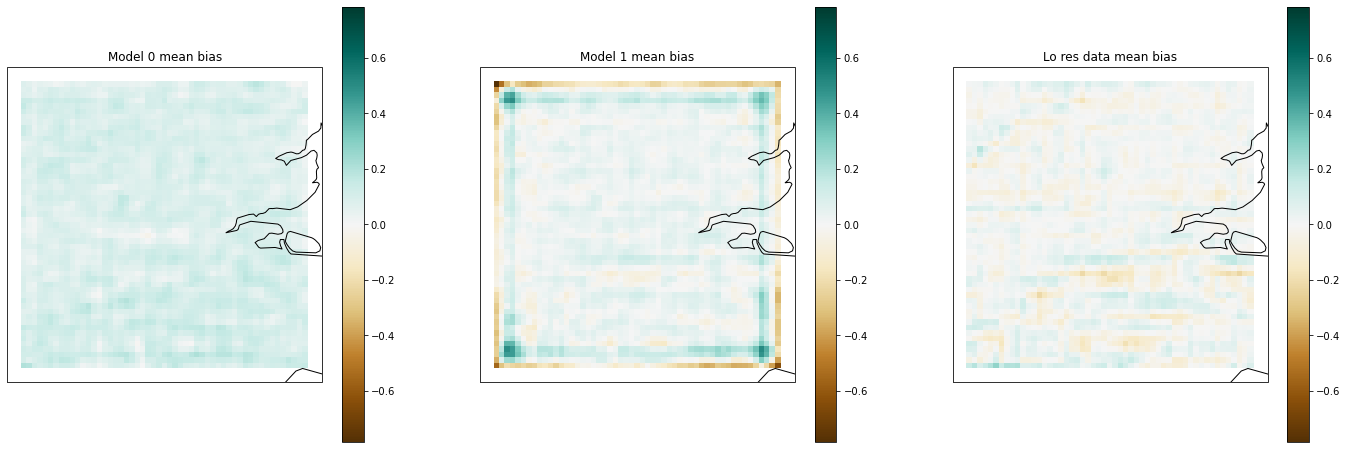

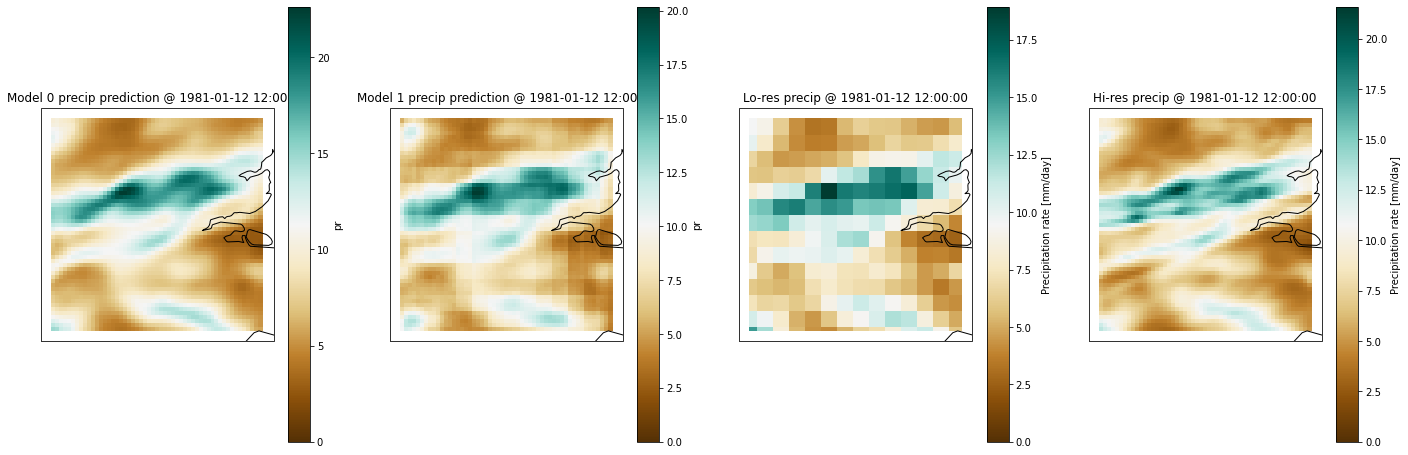

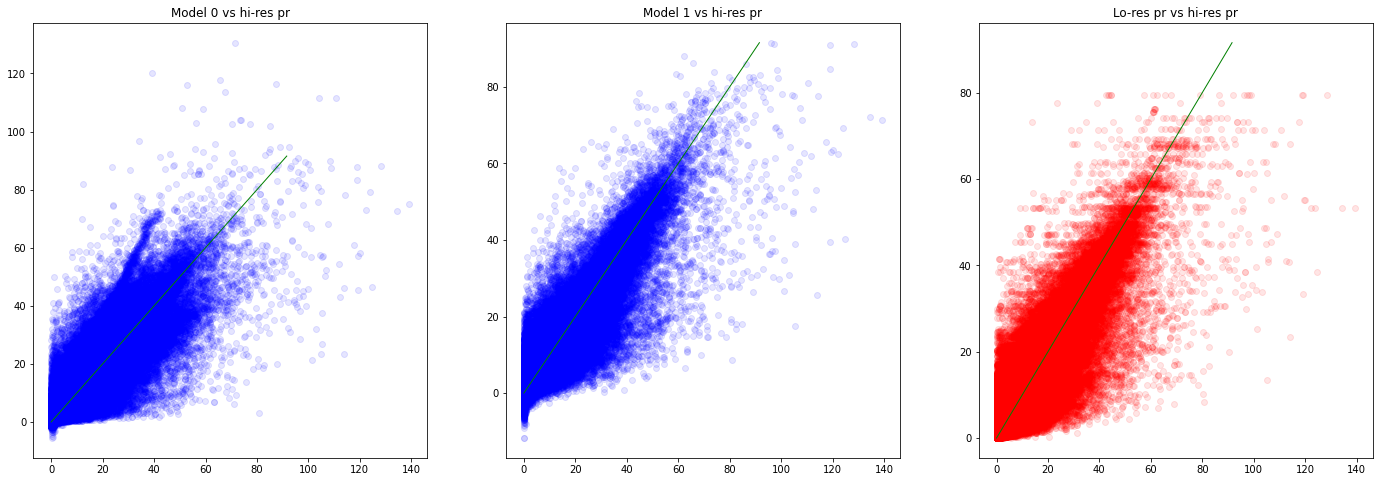

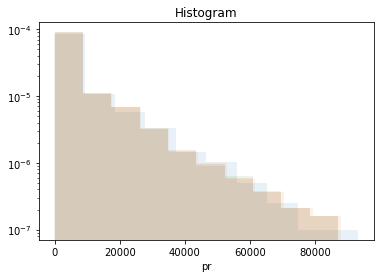

In [67]:
compare_preds([preds["u-net"][4], preds["simple-conv"][4]], test_sets[4])

## 8x coarsened

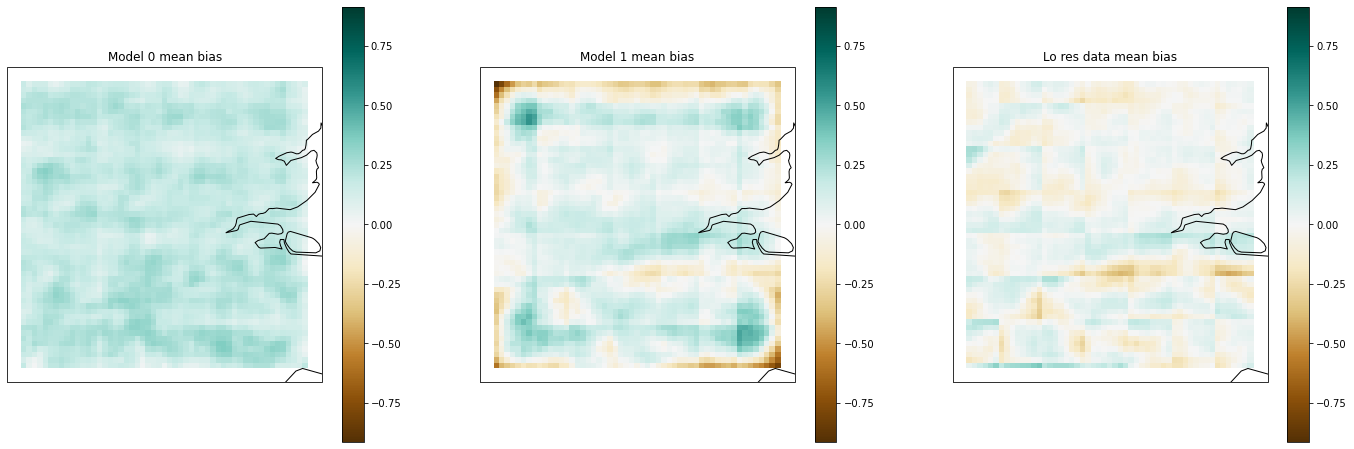

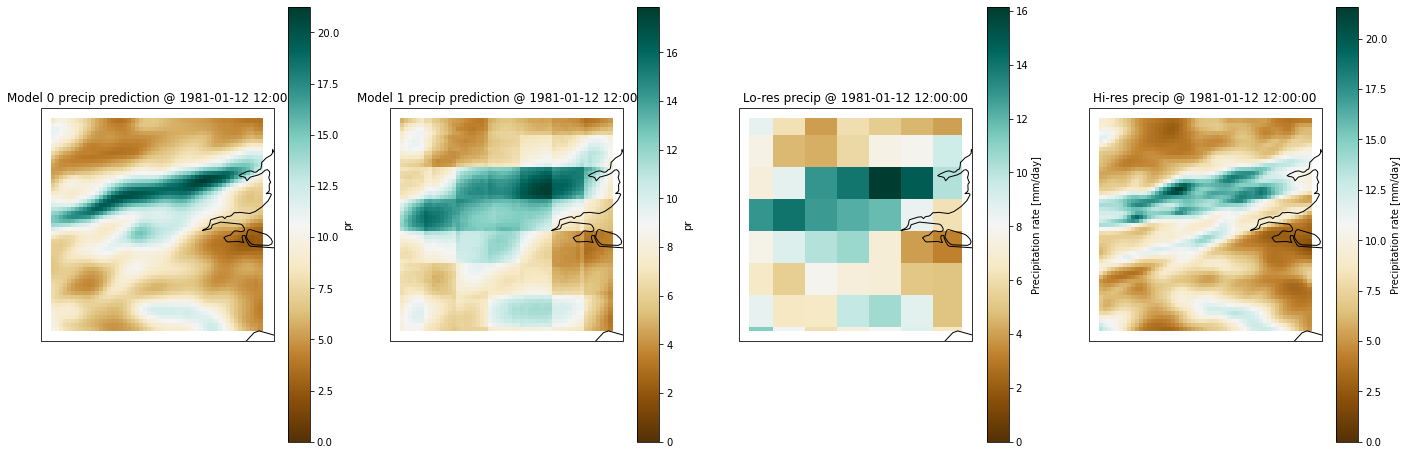

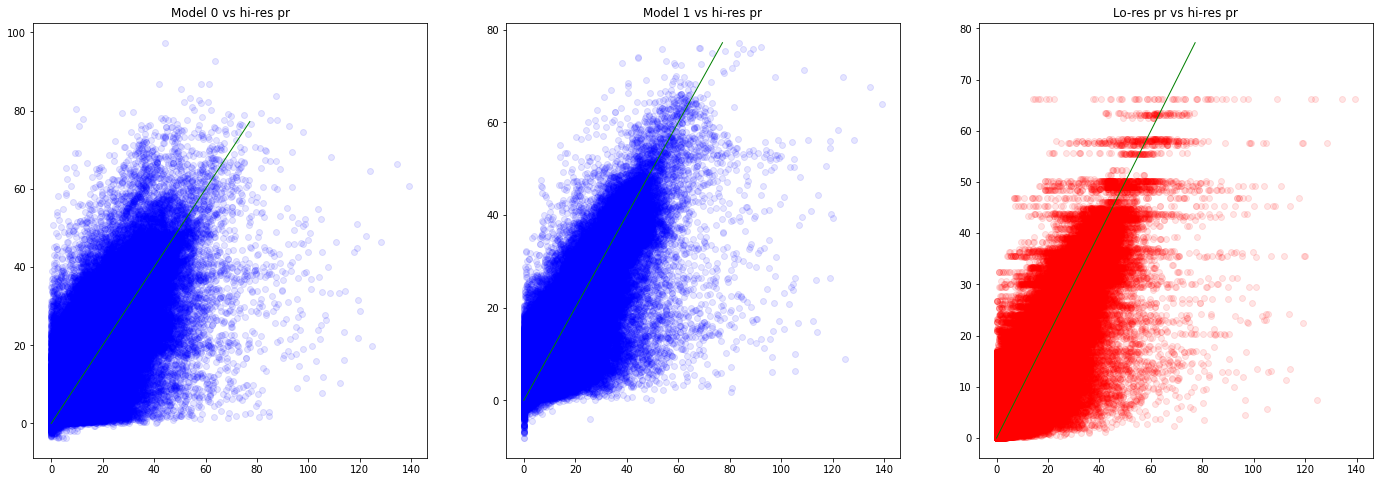

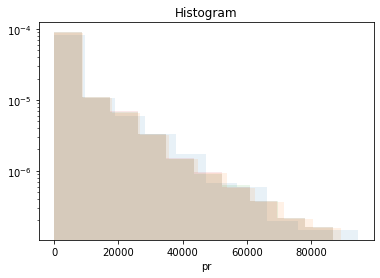

In [68]:
compare_preds([preds["u-net"][8], preds["simple-conv"][8]], test_sets[8])

## 16x coarsened

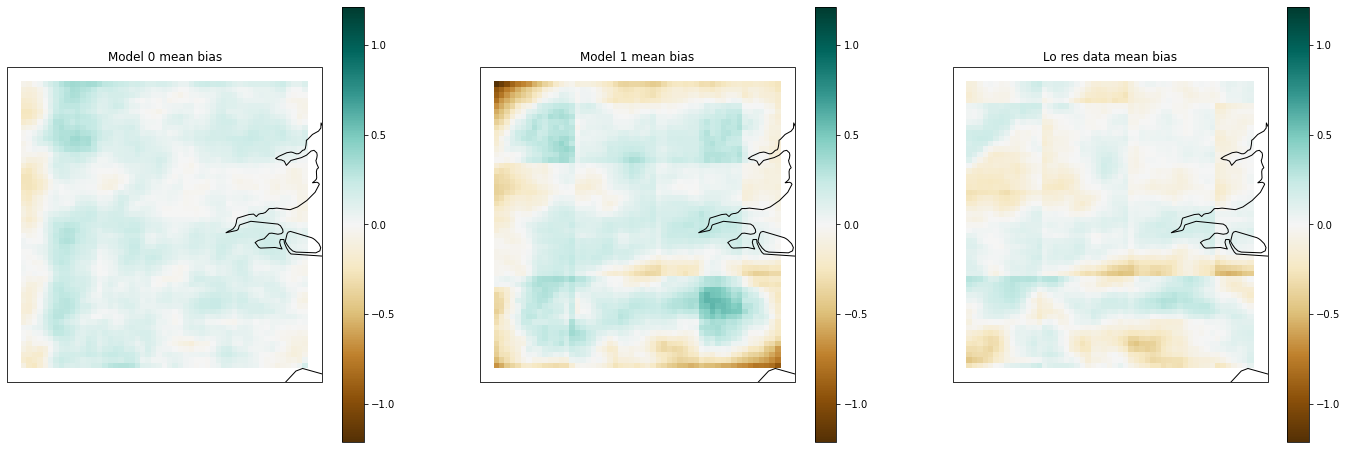

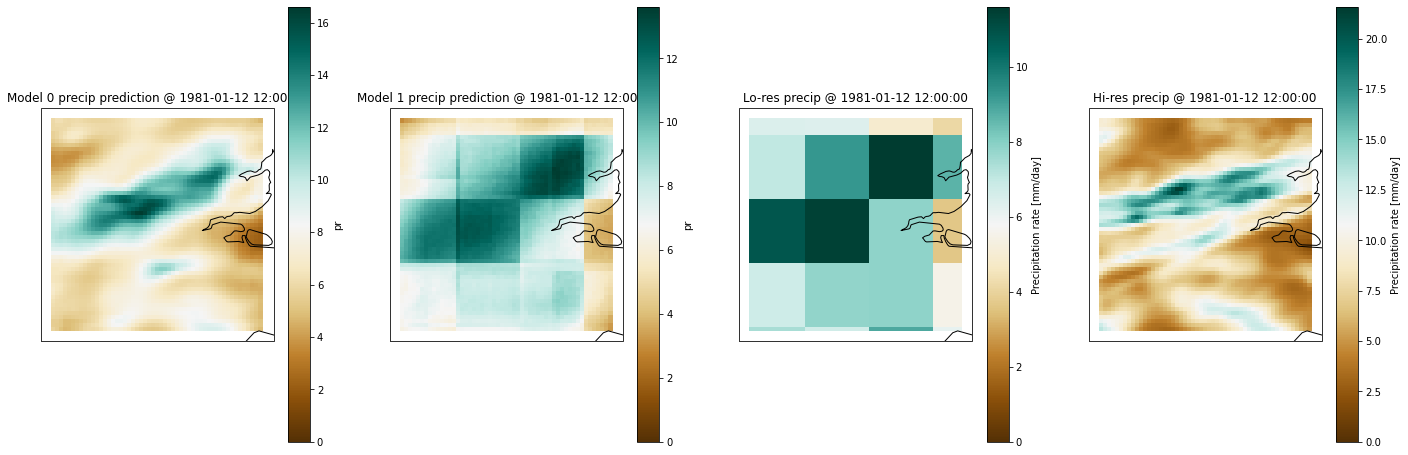

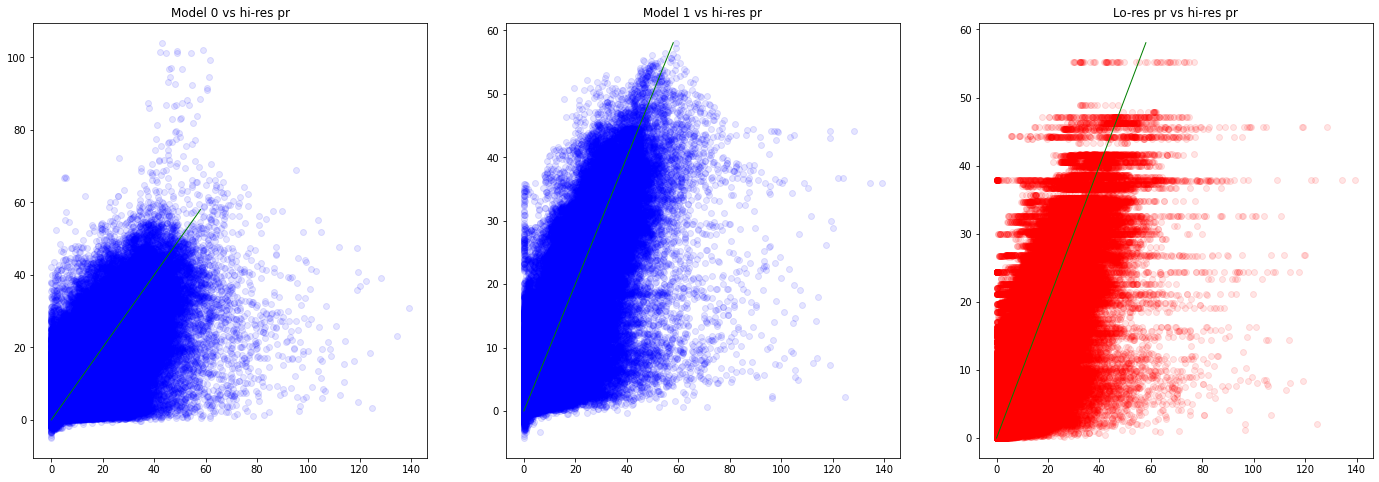

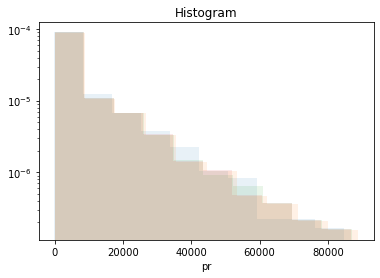

In [69]:
compare_preds([preds["u-net"][16], preds["simple-conv"][16]], test_sets[16])

## 27x coarsened (~GCM resolution)

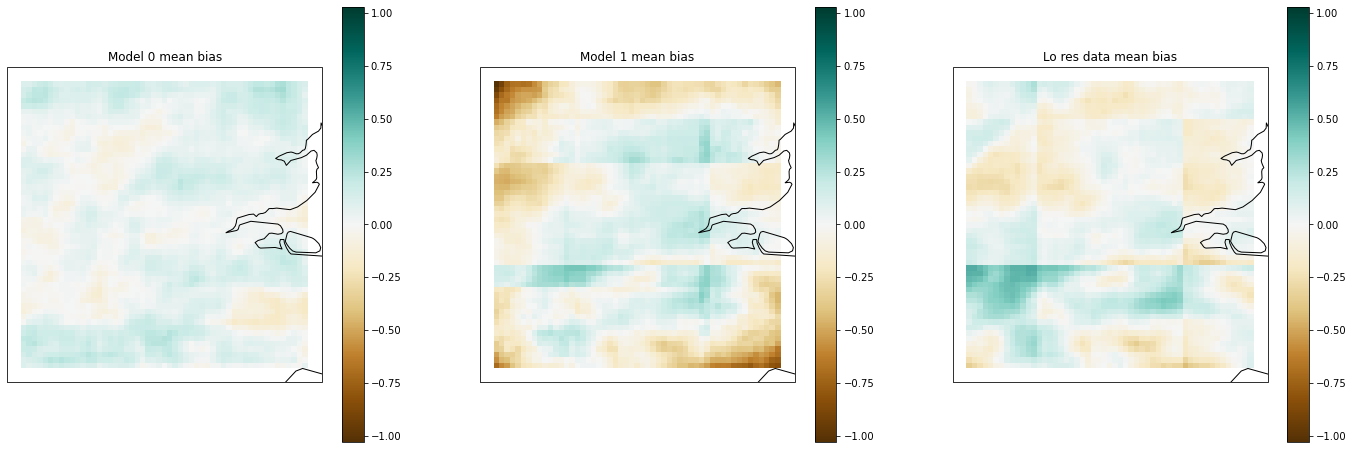

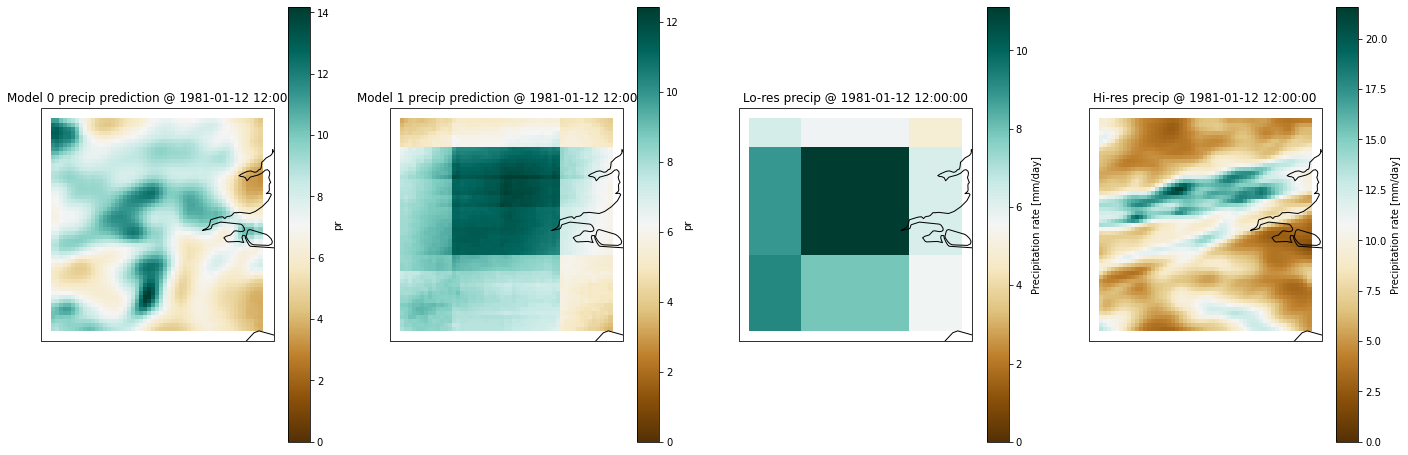

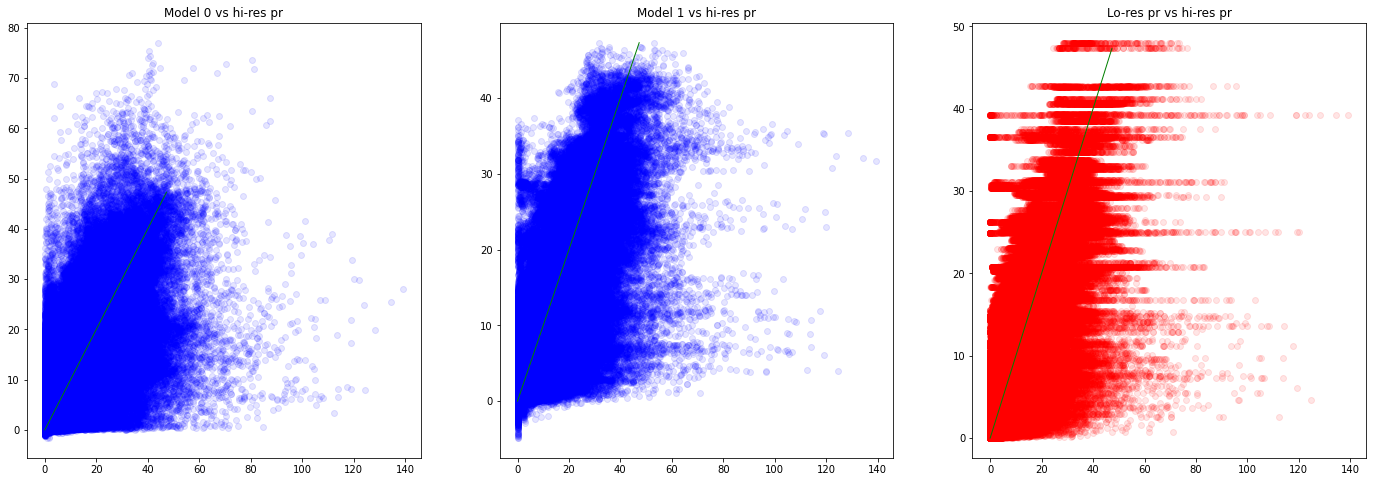

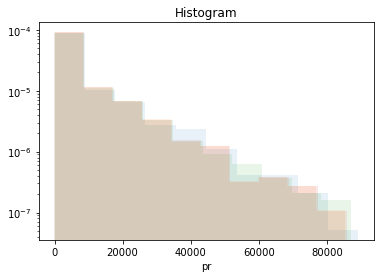

In [70]:
compare_preds([preds["u-net"][27], preds["simple-conv"][27]], test_sets[27])

## Comparing U-Nets with different coarsening scale factors

Plotted below are the U-Net predictions for the 5 different scale factors and beneath them the corresponding coarsened input and below that the residuals. The first column is the target precipitation of the full-resolution CPM output.

There are three rows for 10 randomly selected timestamps from the test set.

In [89]:
rng = np.random.default_rng(seed=42)
timestamps = rng.choice(test_sets[2].time, 10)
timestamps = np.append(timestamps, test_sets[2].time[0])

unet_datasets = [test_sets[2].target_pr]+[preds["u-net"][sf]['pr'] for sf in scale_factors]
input_datasets = [test_sets[2].target_pr]+[test_sets[sf]['pr'] for sf in scale_factors]
residual_datasets = [test_sets[2].target_pr - test_sets[2].target_pr] + [test_sets[sf].target_pr - preds["u-net"][sf]['pr'] for sf in scale_factors]

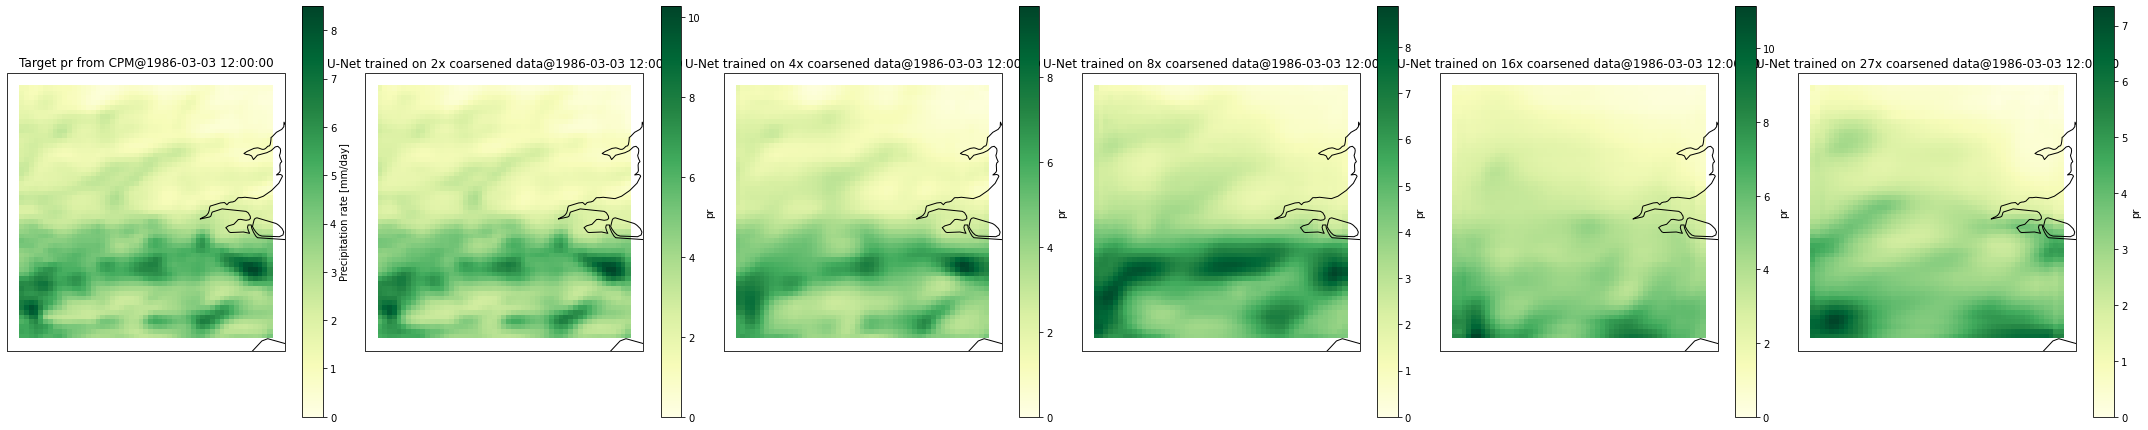

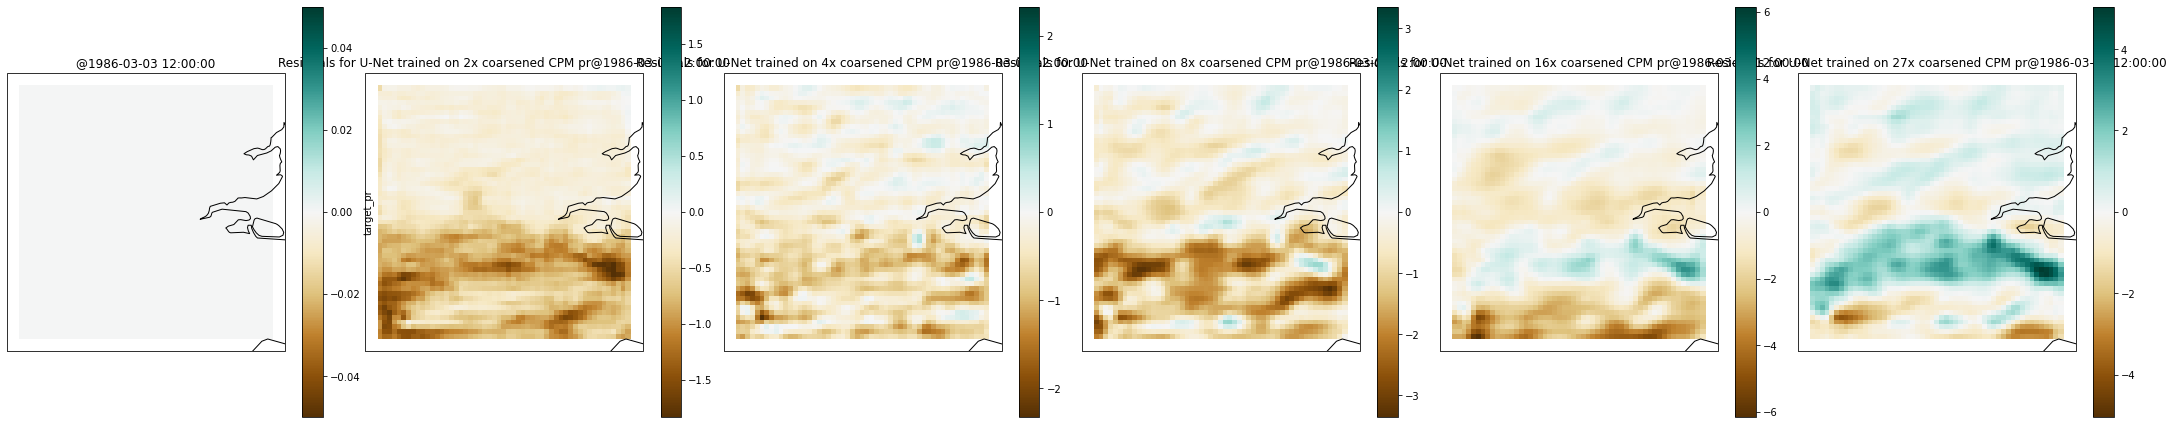

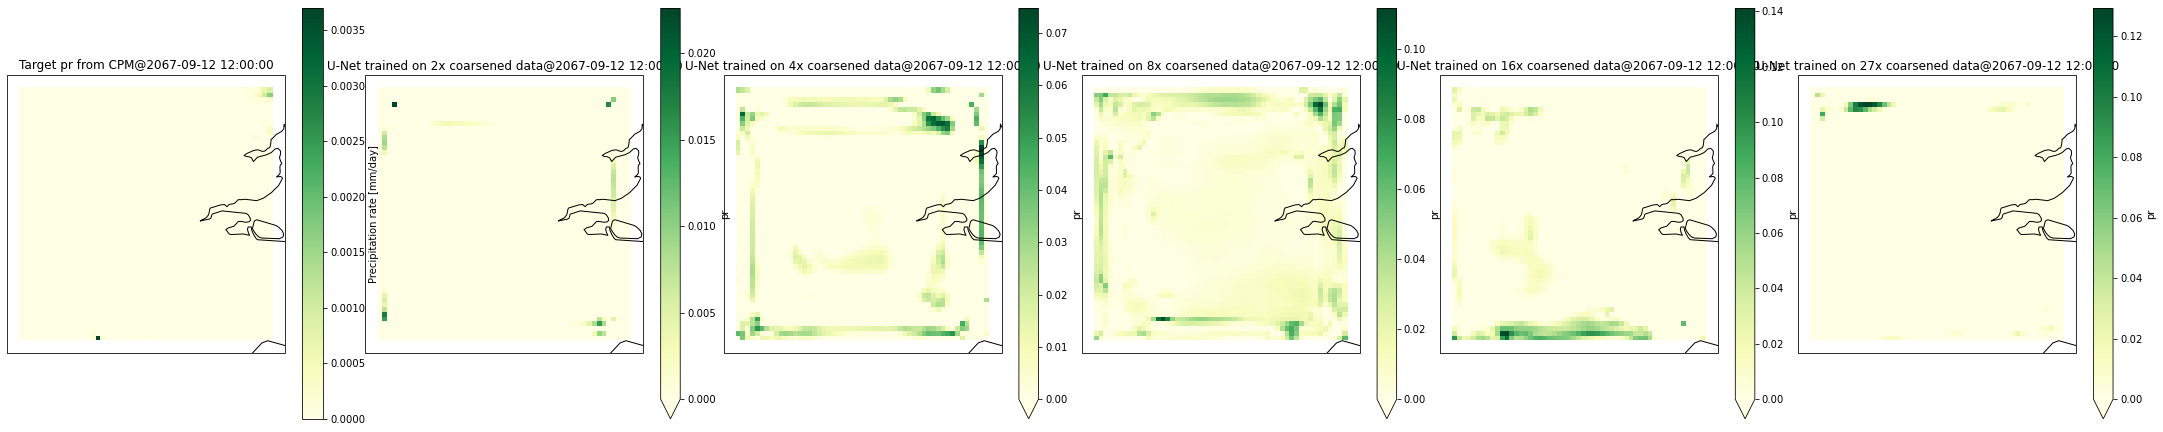

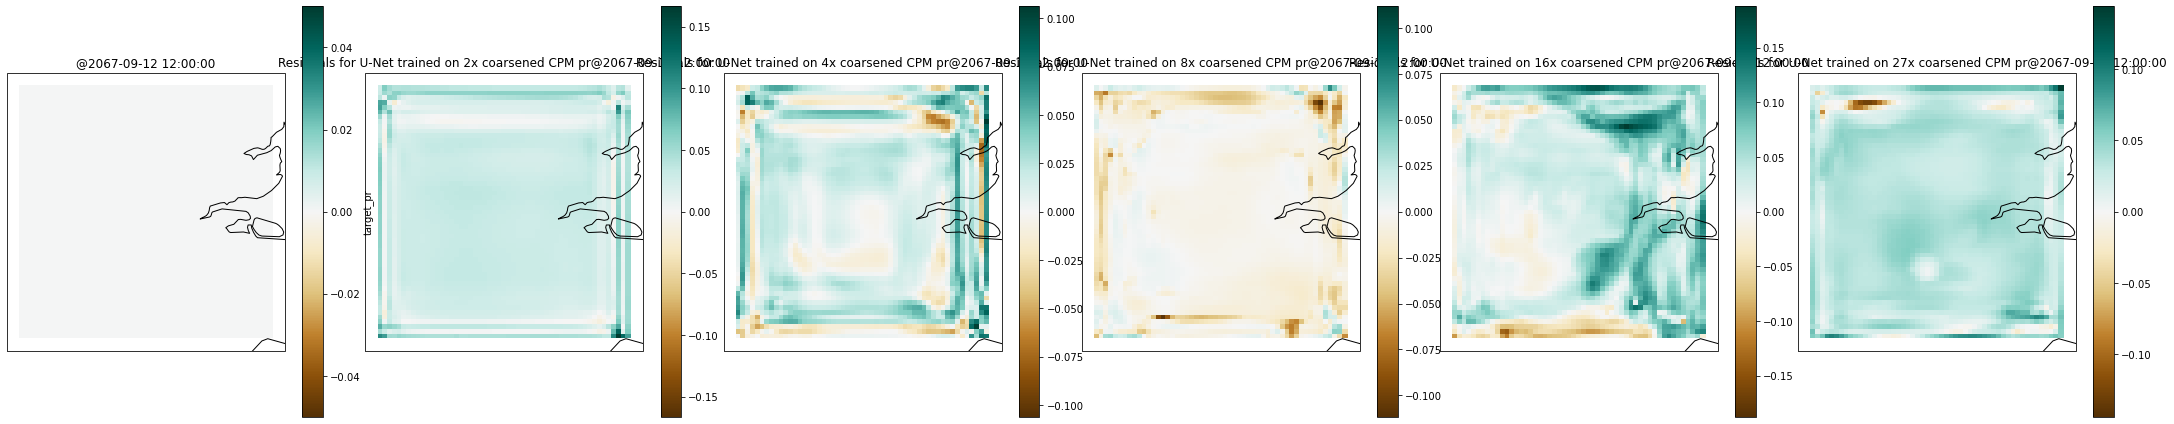

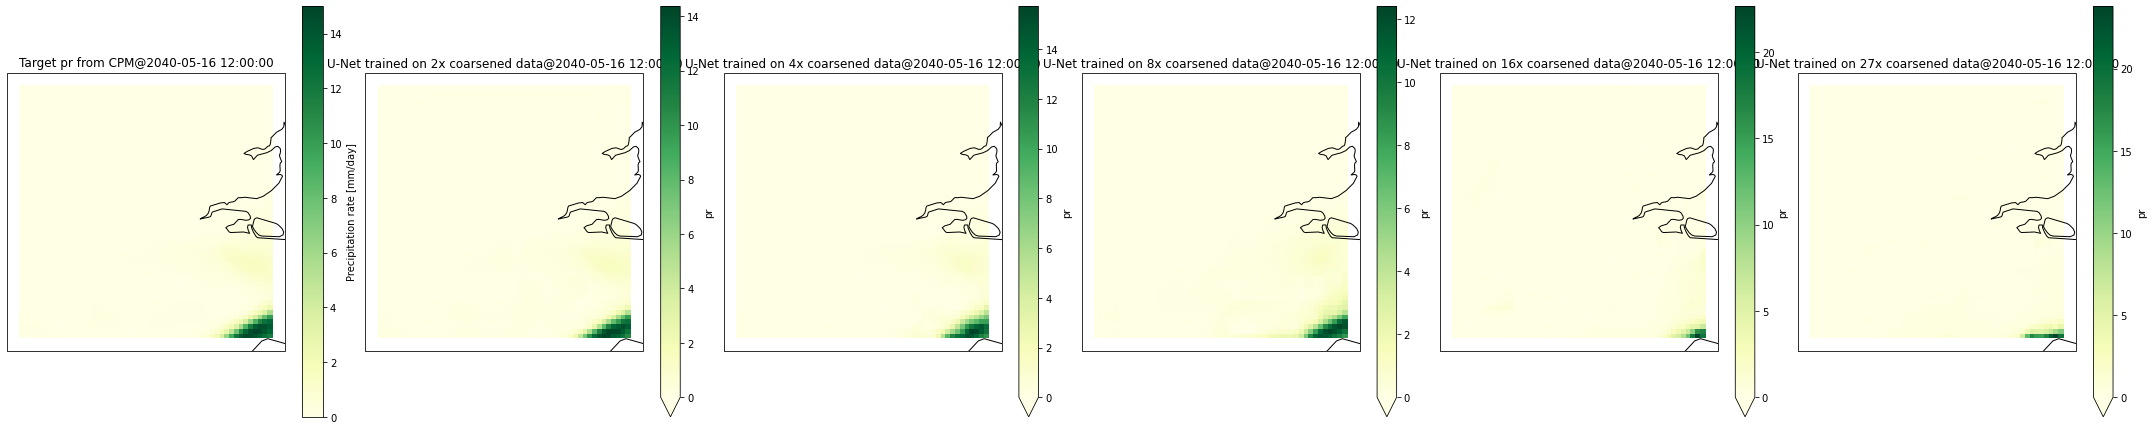

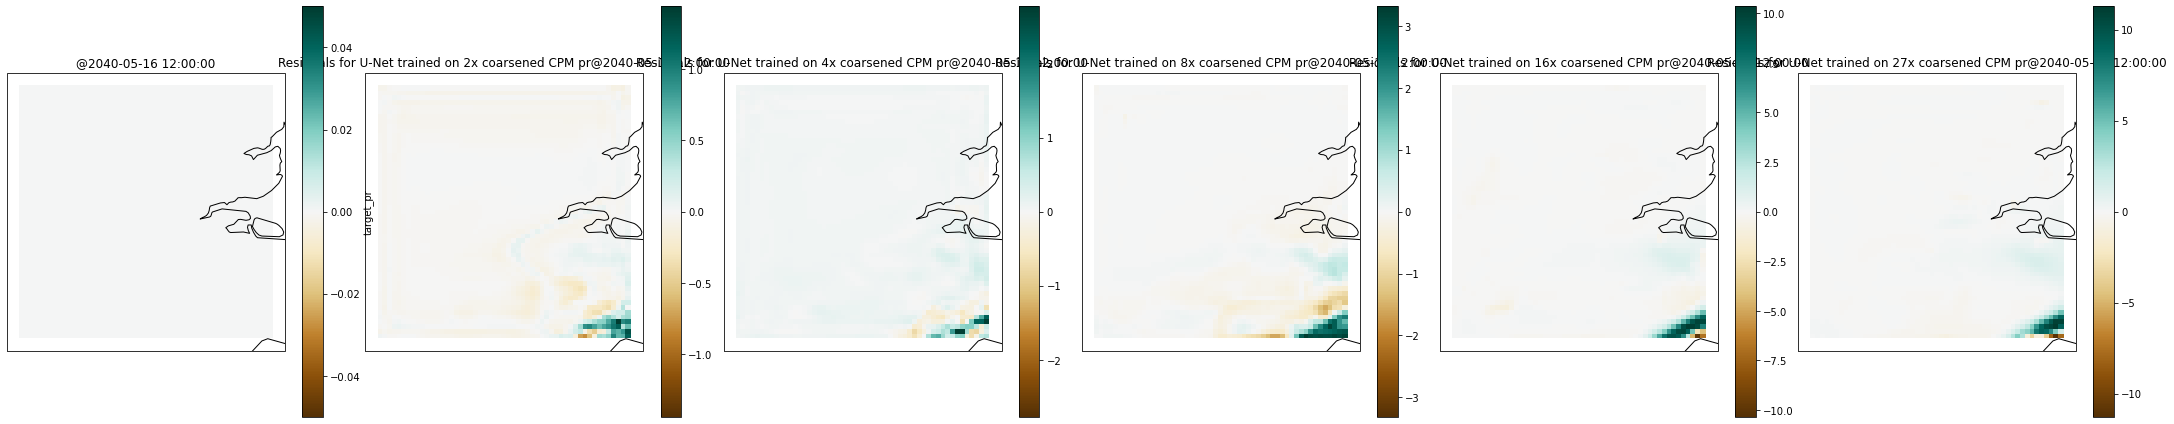

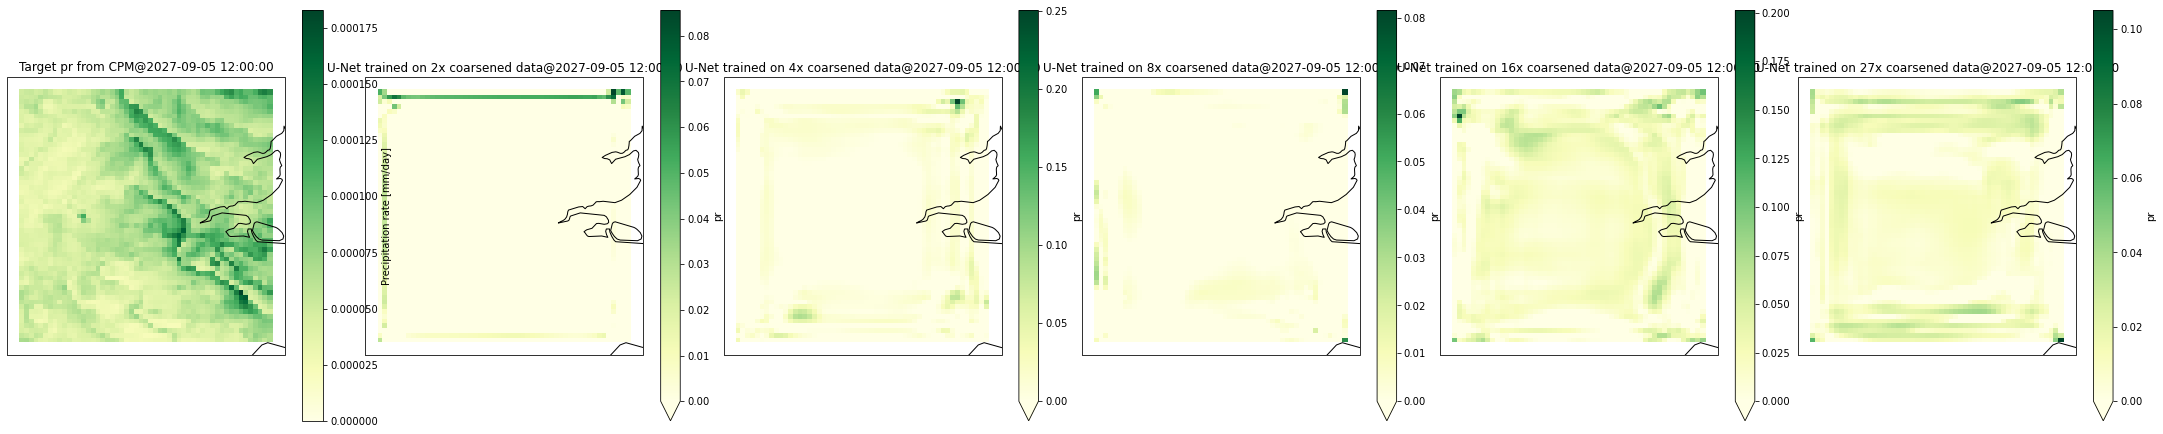

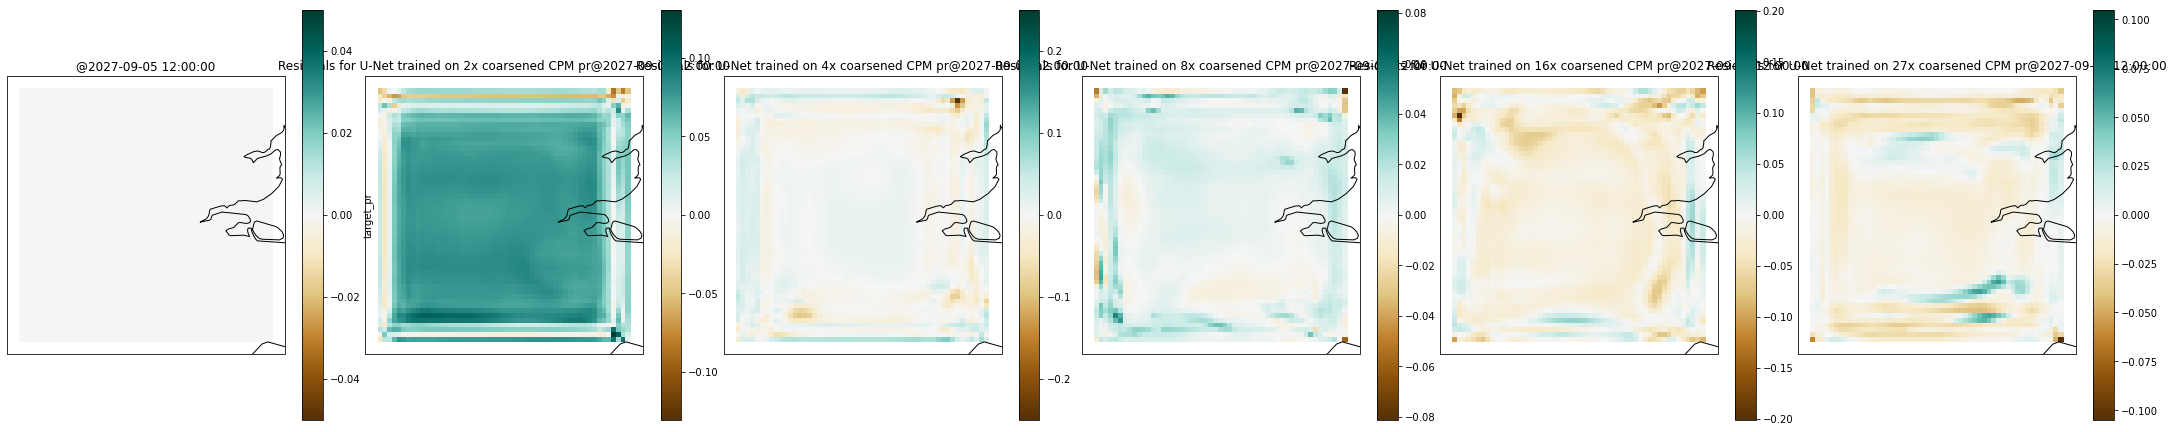

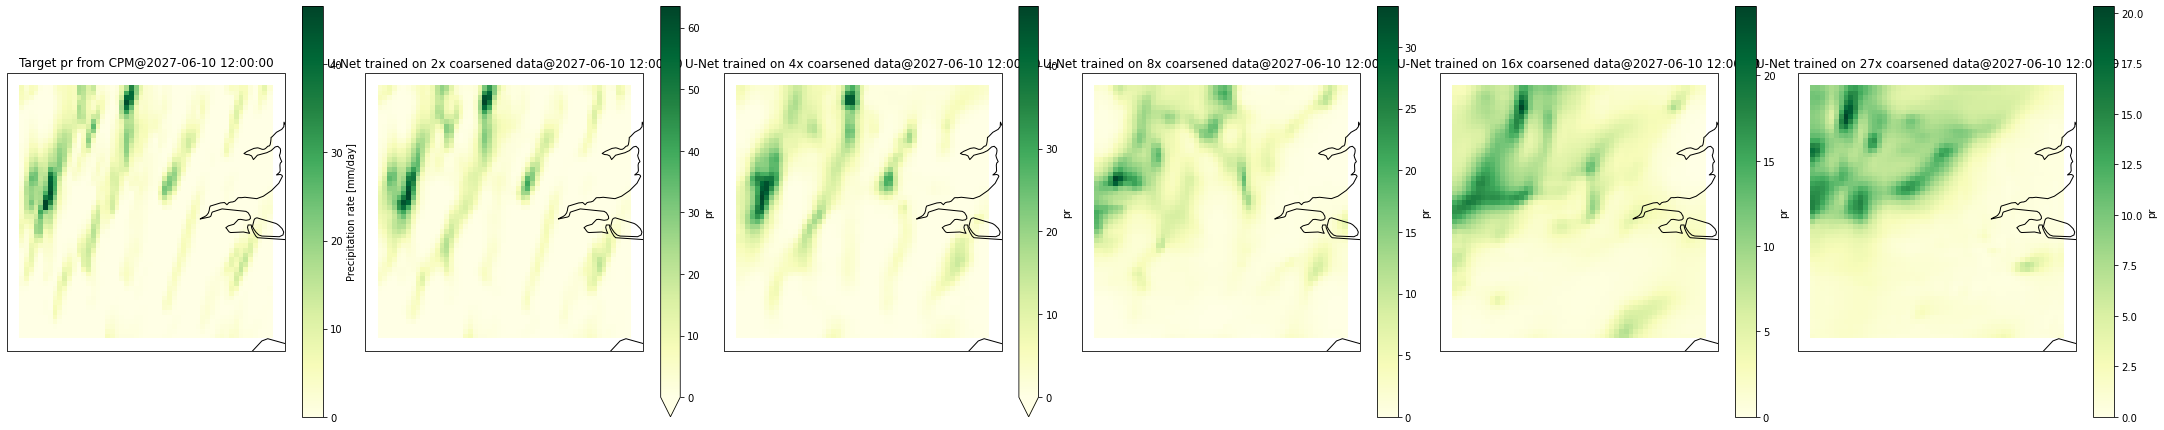

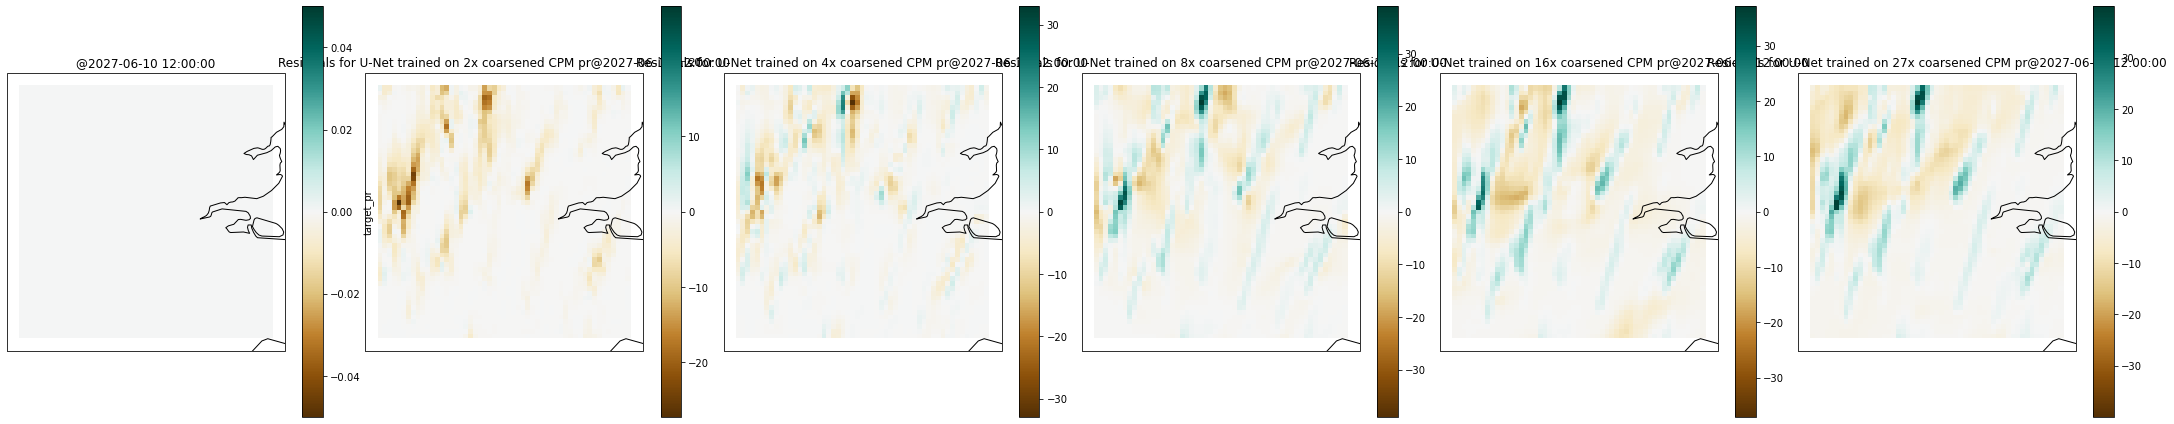

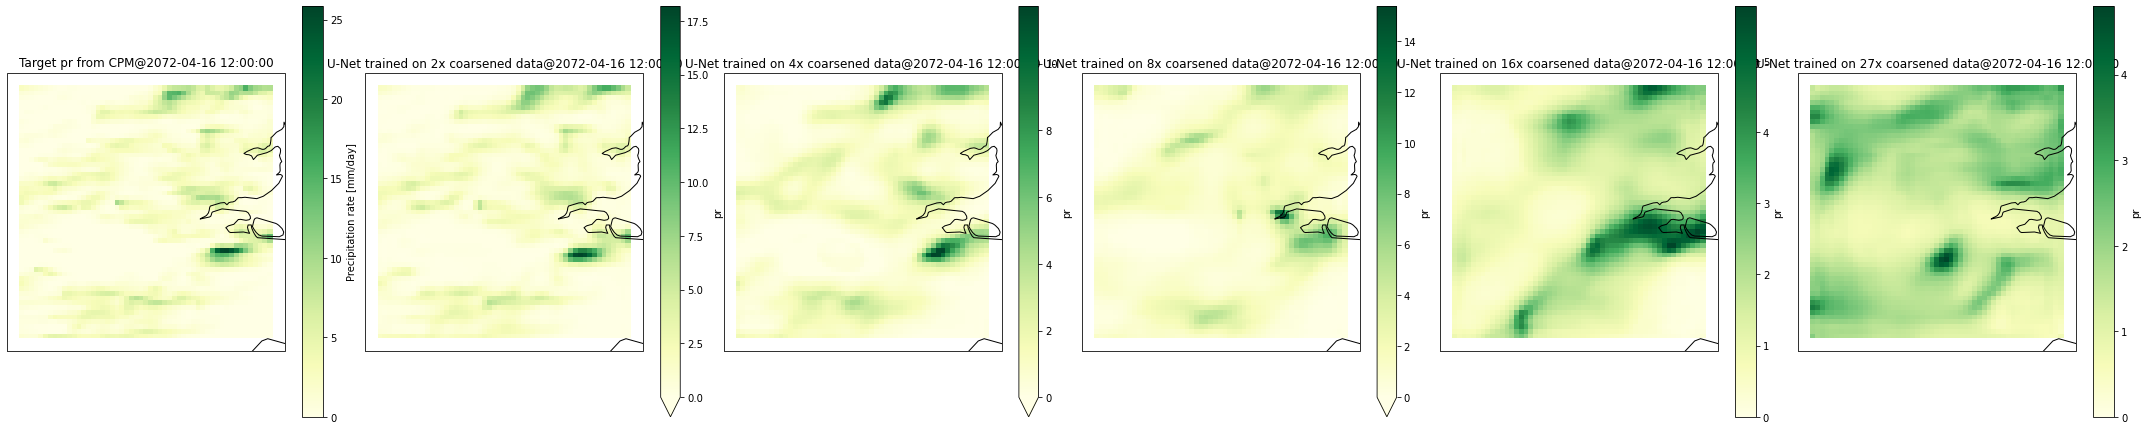

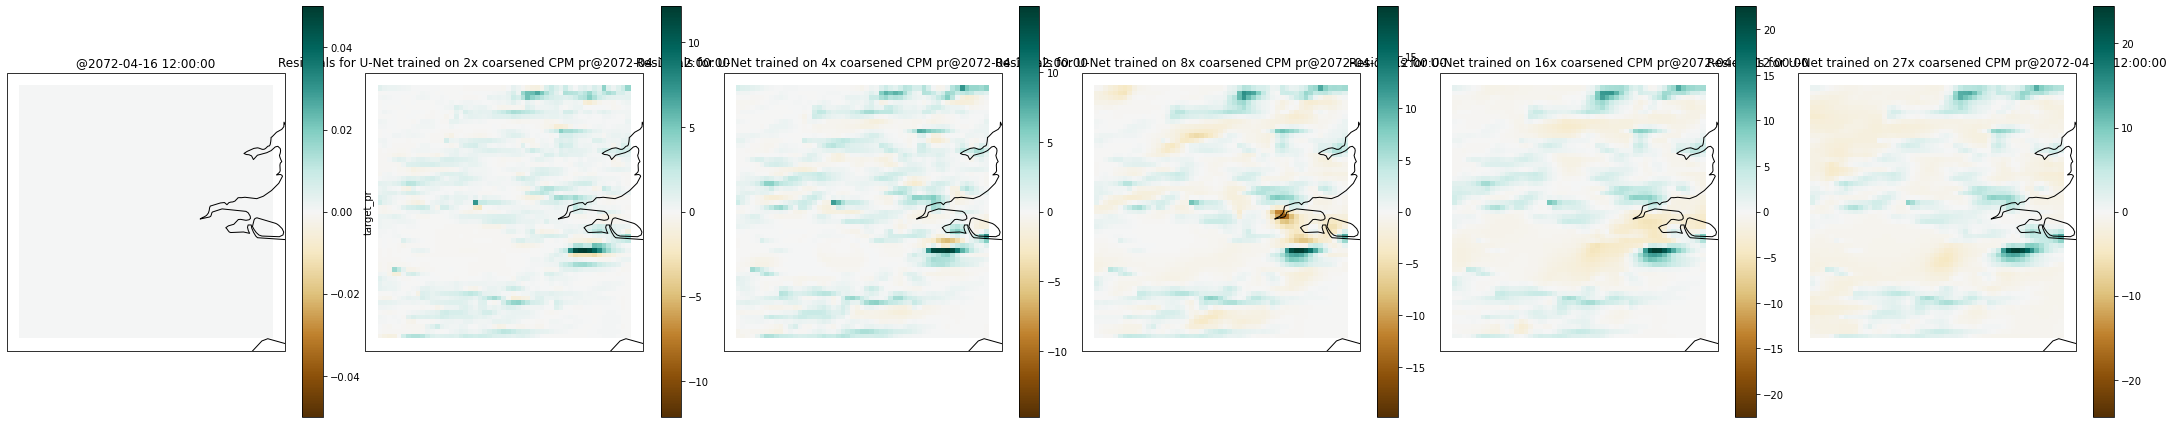

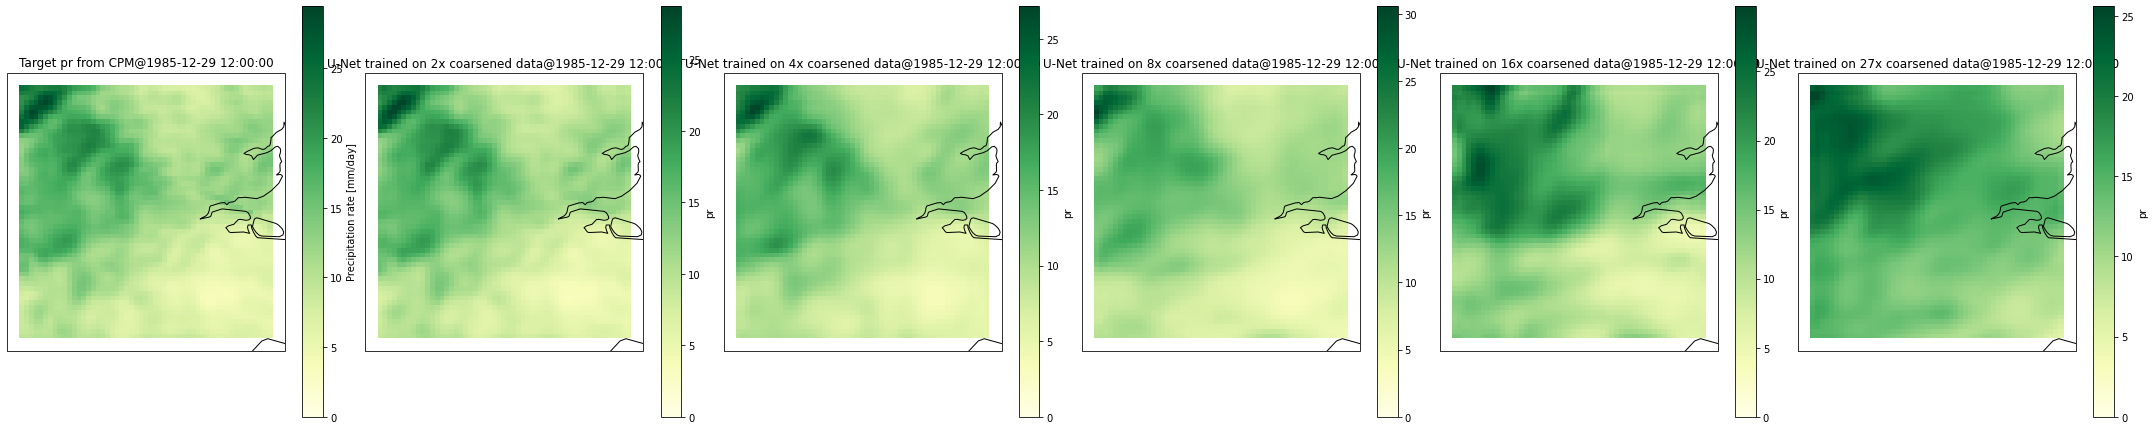

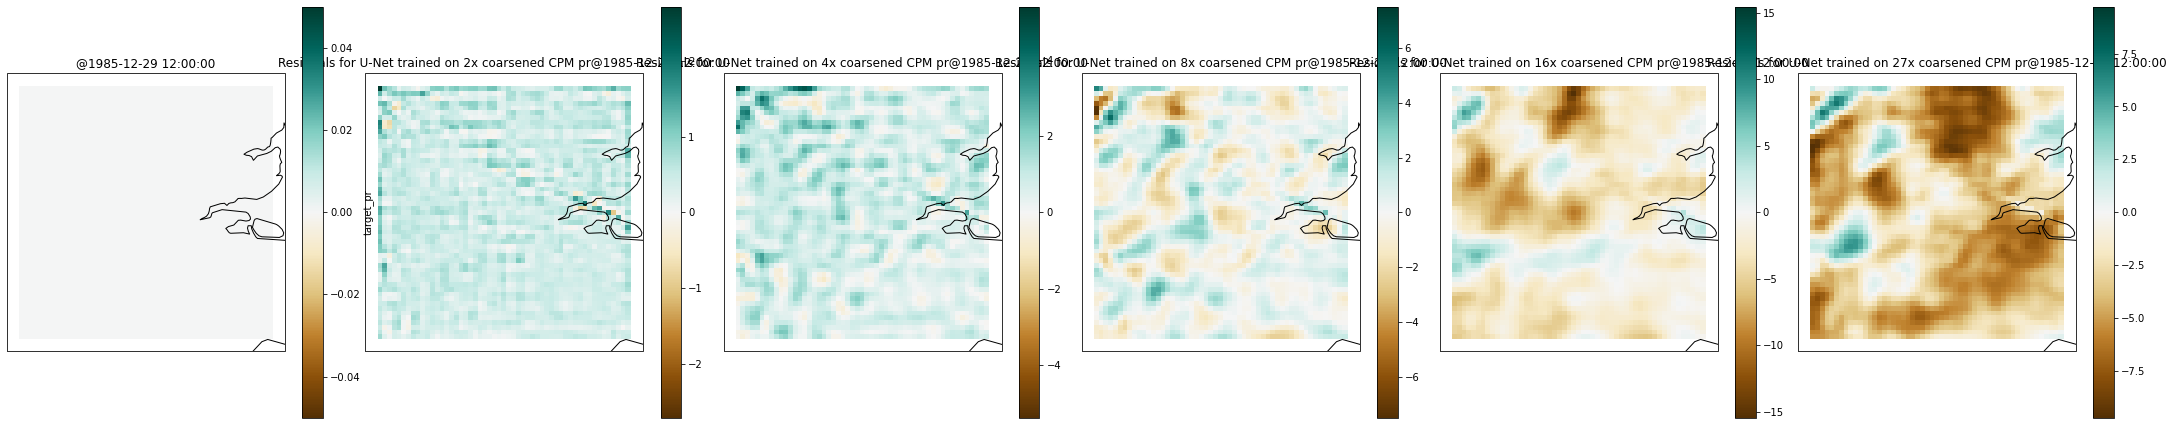

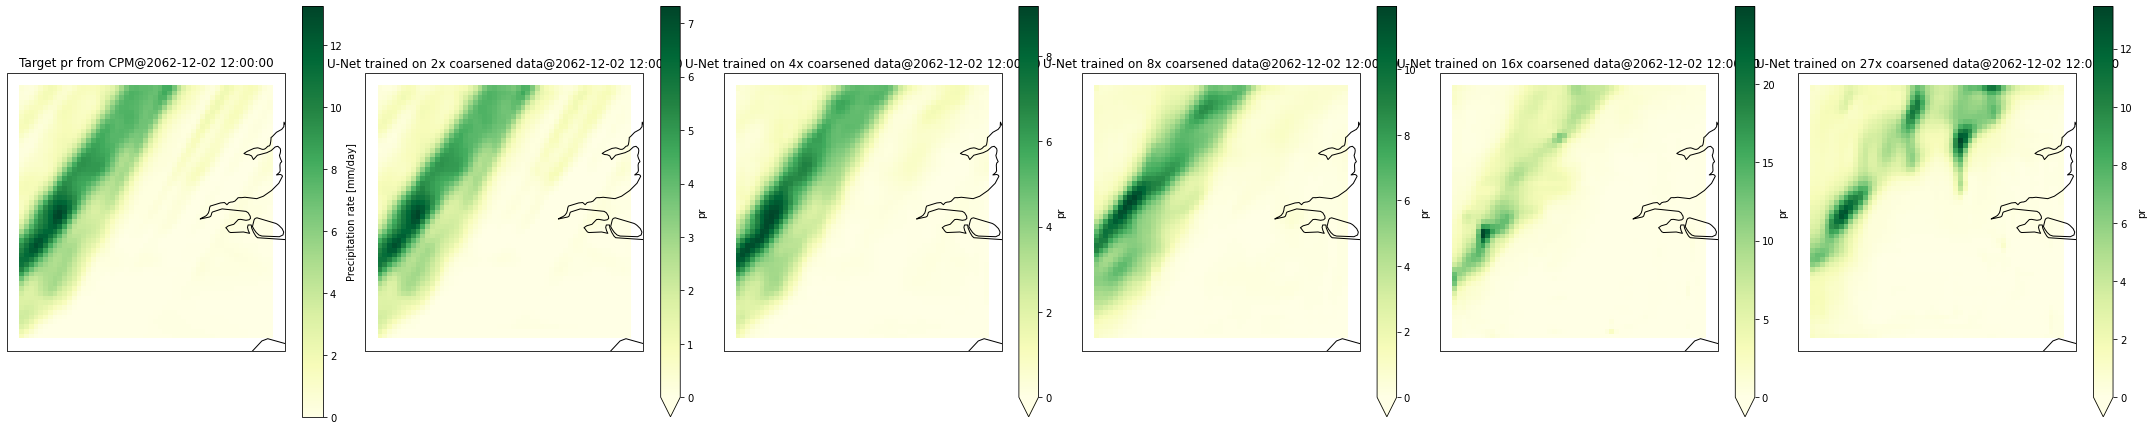

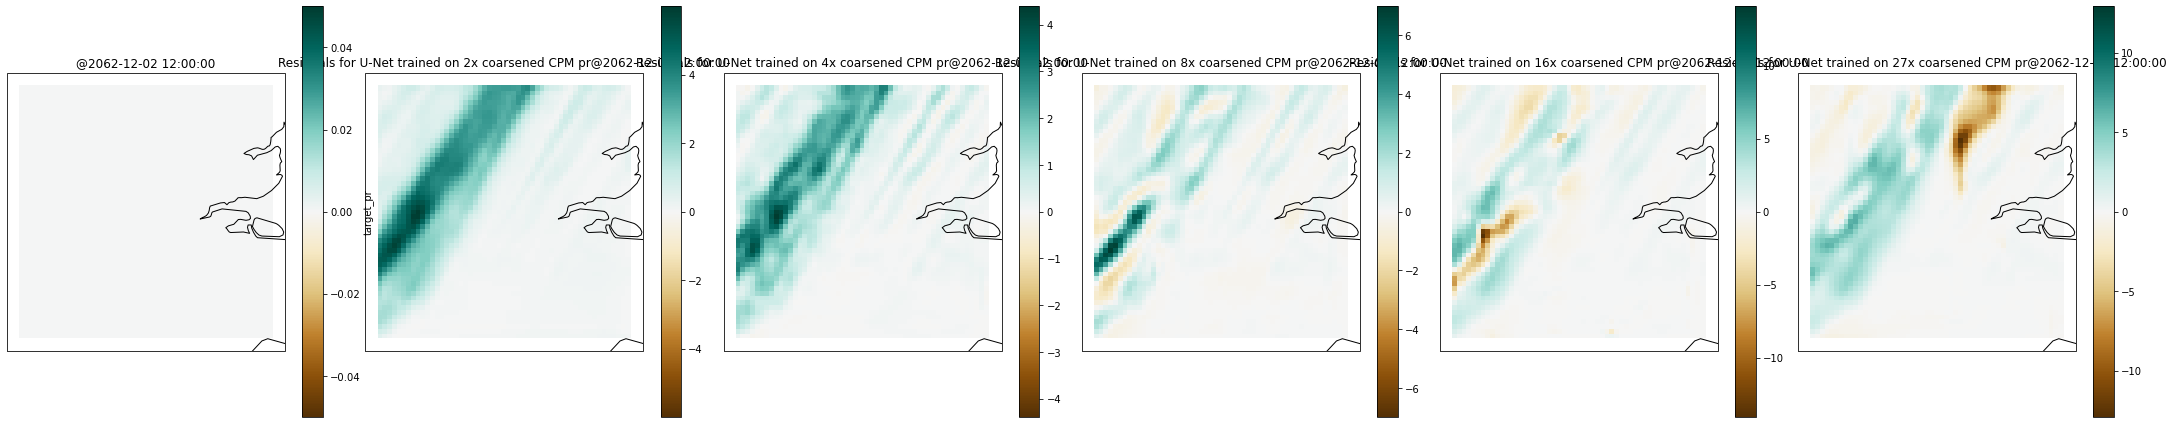

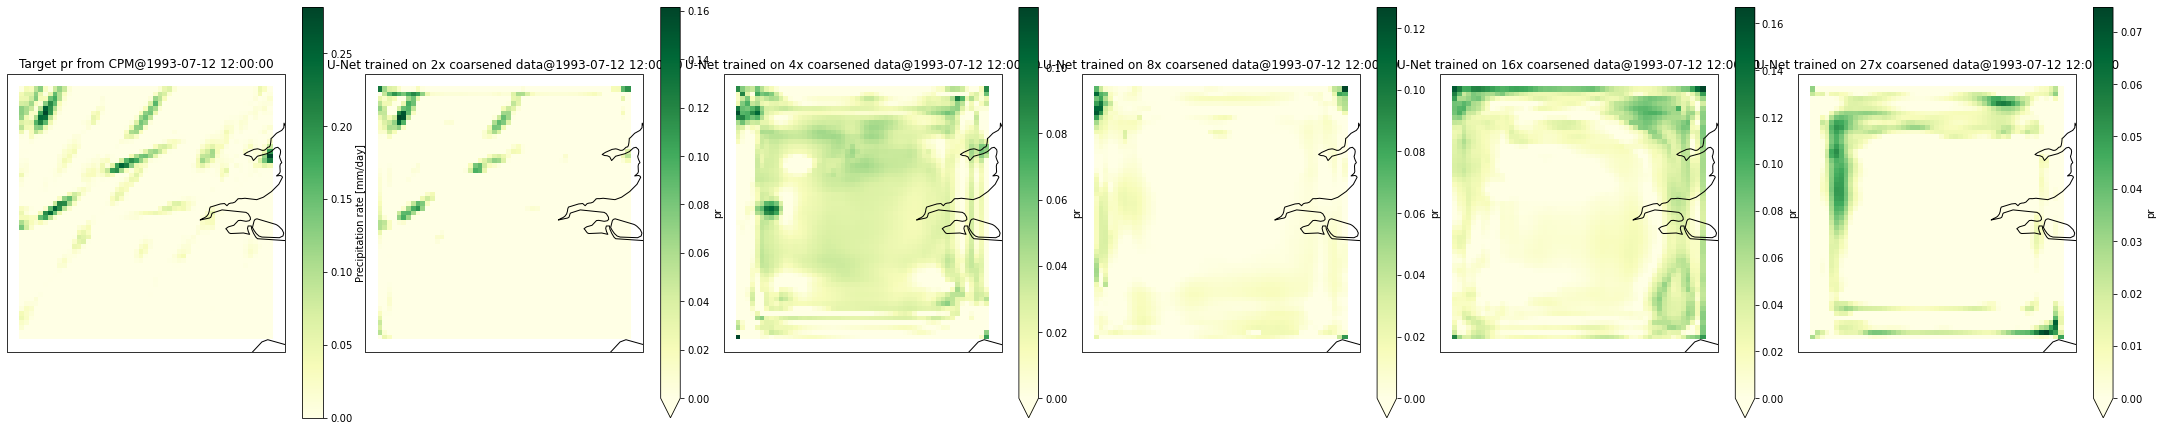

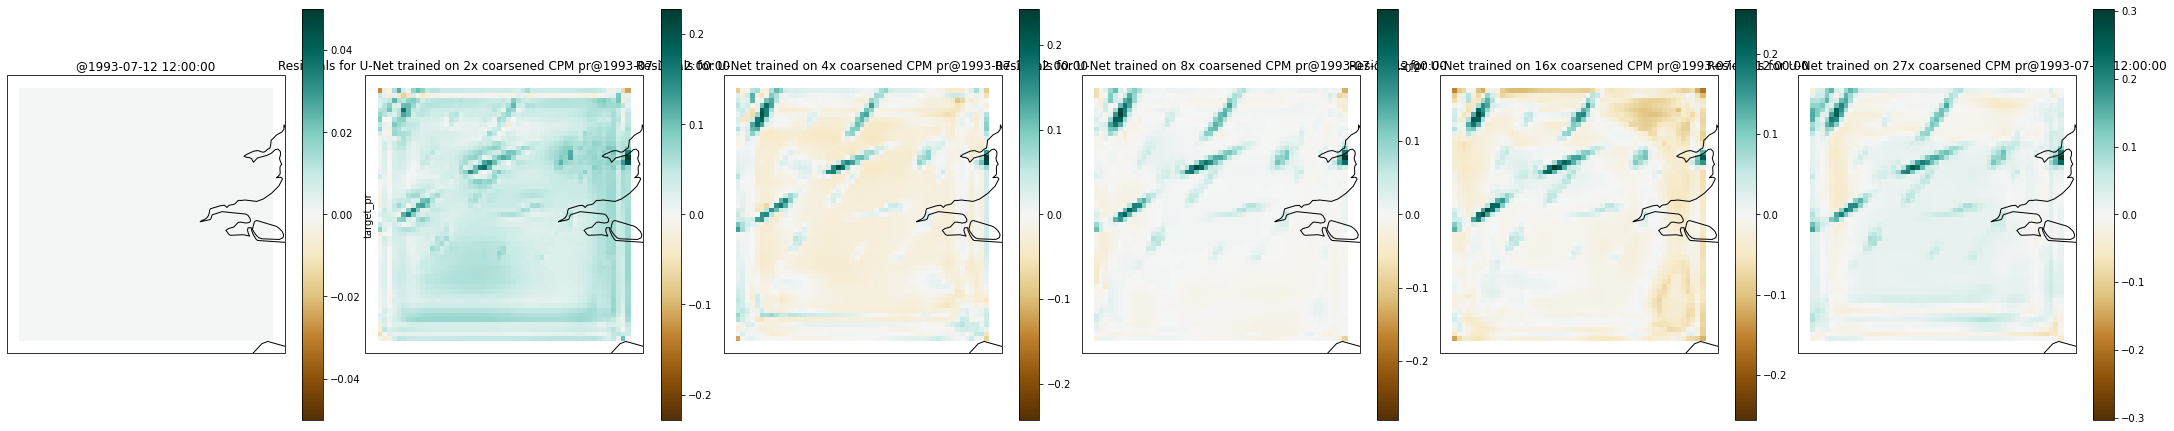

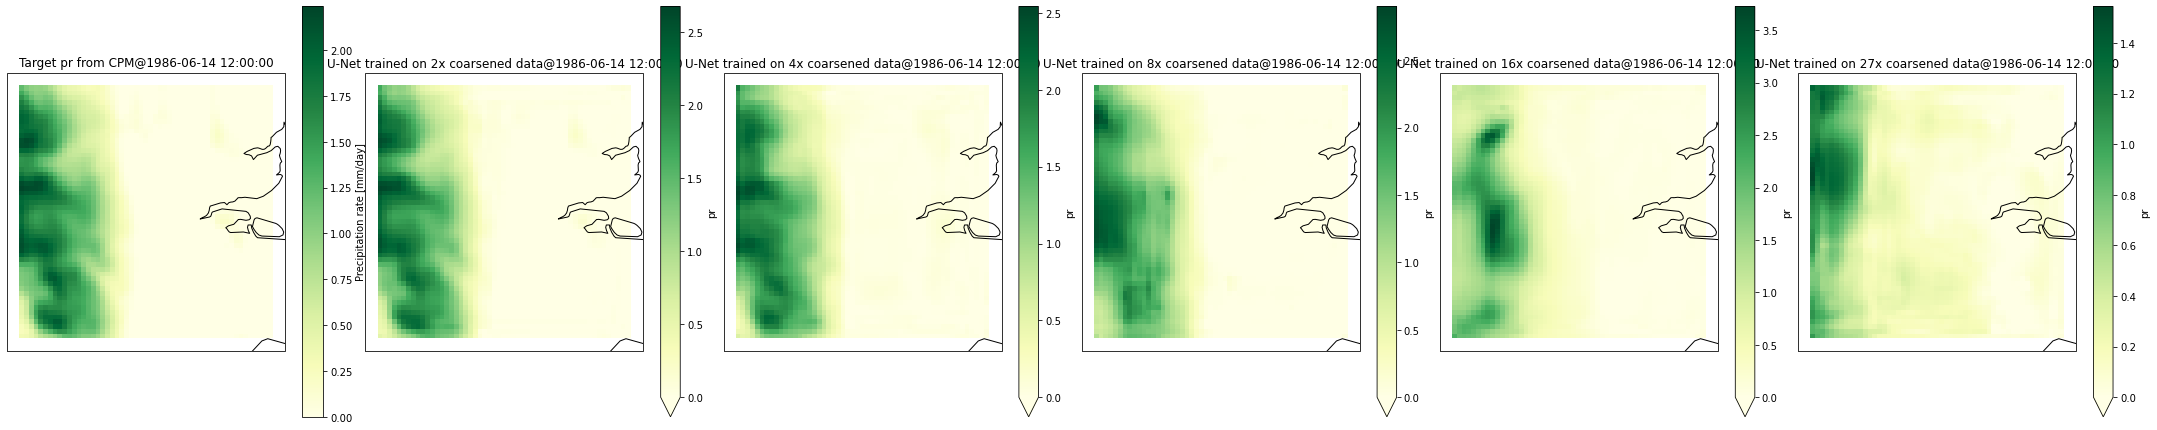

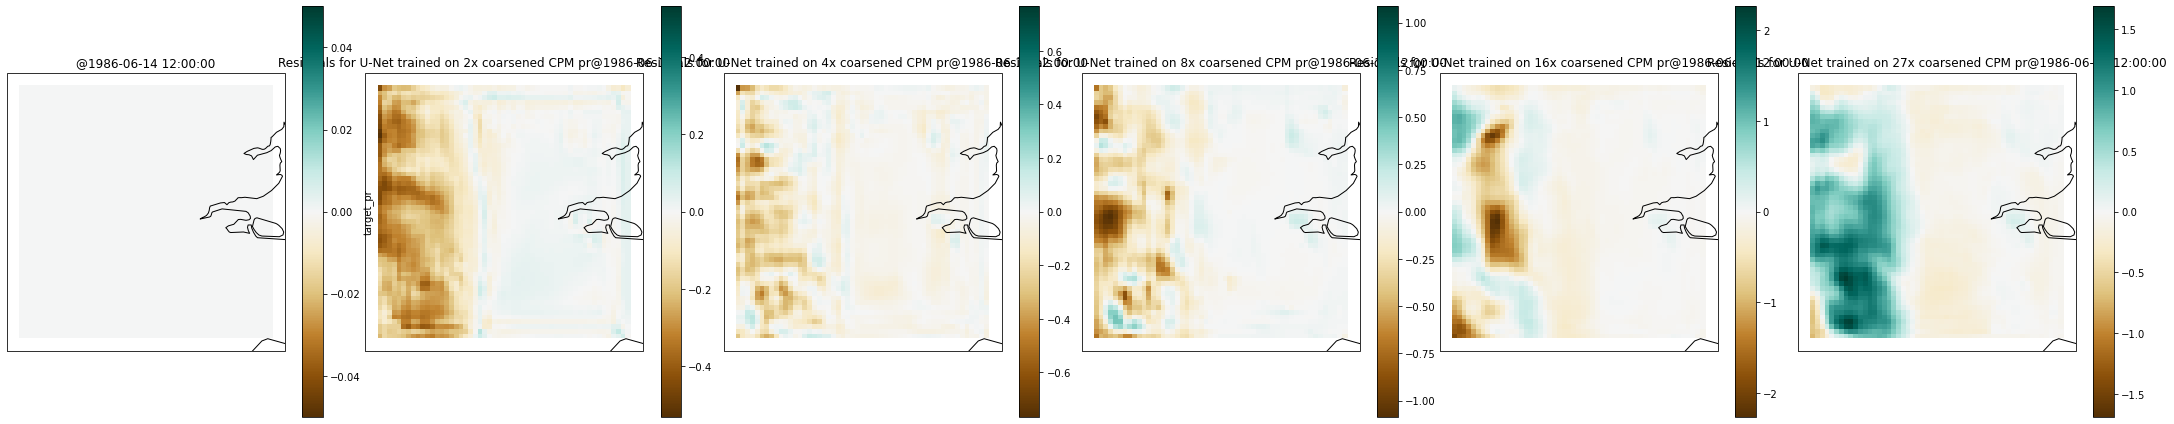

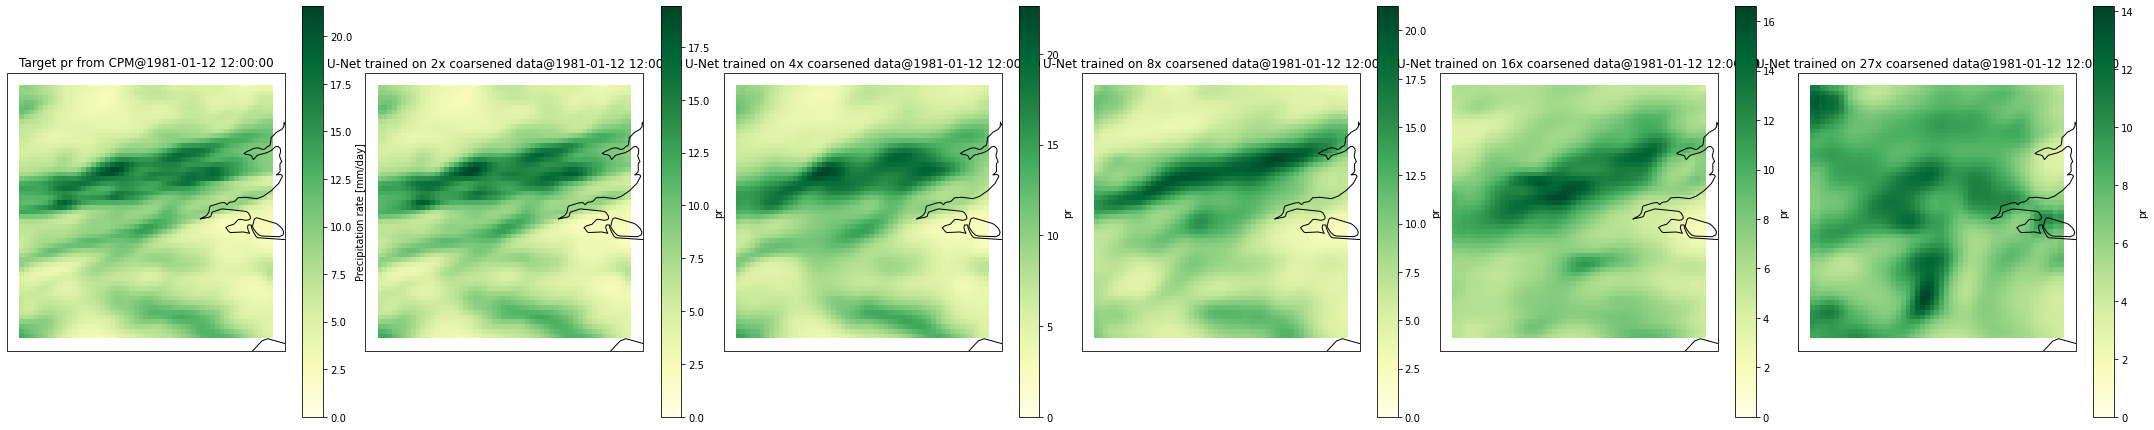

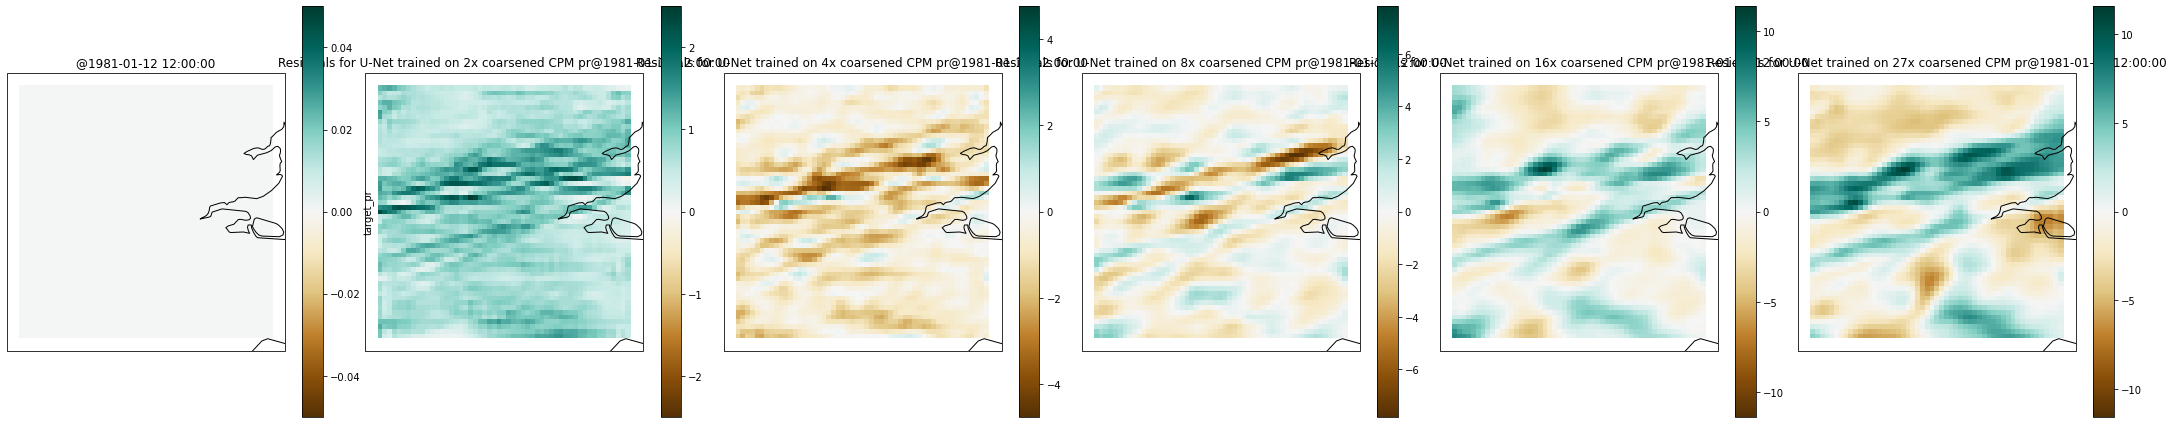

In [92]:
vmax = None#45 # max(*[ds.max().values for ds in unet_datasets+input_datasets])
import matplotlib.pyplot as plt
for timestamp in timestamps:
    plots_at_ts(unet_datasets, timestamp, titles=["Target pr from CPM"]+[f"U-Net trained on {sf}x coarsened data" for sf in scale_factors], vmax=vmax)
#     plots_at_ts(input_datasets, timestamp, titles=["Target pr from CPM"]+[f"{sf}x coarsened CPM pr" for sf in scale_factors], vmax=vmax, cmap='Greens')
    plots_at_ts(residual_datasets, timestamp, titles= [""]+[f"Residuals for U-Net trained on {sf}x coarsened CPM pr" for sf in scale_factors], vmin=None, cmap="BrBG")
    plt.show()